# Welcome

This notebook serves as an example to how we can detect modal filters using OpenStreetMap data in python. Any issues, please contact me at b8008458@newcastle.ac.uk!

We begin with importing the necessary libraries. There should be a .yml file on the GitHub repository which can be used to set up the correct environment. We also update OSMNx to ensure all the OSM tags we need are avaiable and ready. 

In [48]:
# Library imports
import geopandas as gpd
import osmnx as ox
import networkx as nx
import momepy
from shapely import Polygon
import matplotlib.pyplot as plt
import folium
import pandas as pd
import overpy
from shapely.geometry import LineString
from shapely.geometry import Point
import requests
from shapely.geometry import MultiPolygon

In [49]:
# update osmnx settings
useful_tags_ways = ox.settings.useful_tags_way + ['cycleway'] + ['bicycle'] + ['motor_vehicle'] + ['railway'] + ['tunnel'] + ['barrier'] + ['bus'] + ['access'] + ['oneway'] + ['oneway:bicycle'] + ['covered'] + ['waterway']
ox.config(use_cache=True, 
          log_console=True,
          useful_tags_way=useful_tags_ways
          )

C:\Users\b8008458\AppData\Local\Temp\ipykernel_19628\305956182.py:3: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True,


Now we set the location of our example area. Feel free to try your own place (provided it is within the UK)

In [50]:
# set place
place = "Newcastle Upon Tyne, United Kingdom"

In [51]:
#  boundary

boundary = ox.geocode_to_gdf(place)
boundary = boundary.to_crs('EPSG:27700')

# buffer boundary to ensure clips include riverlines which may act as borders between geographies
boundary_buffered = boundary.buffer(50)


# plot boundary (always best to double check!)
boundary.explore()

We can now begin to find modal filters. We begin with accessing the street network for the study area. The street network is from OpenStreetMap, which *should* provide us with a good representation of reality. Feel free to check the street network by using streets_gdf.explore() or ox.plot_graph_folium(streets)

In [52]:
## get street network for the study area

# get the boundary in the correct CRS for OSMnx
boundary_4326 = boundary.to_crs('EPSG:4326')

# OSM is used over OS datasets as OSM is better for non-driving streets
streets = ox.graph_from_polygon(boundary_4326.geometry.iloc[0], network_type='all')

# Convert the OSMnx graph to a GeoDataFrame of streets
streets_gdf = ox.graph_to_gdfs(streets, nodes=False, edges=True)

### Barrier Filters

The first type of filter we look to access is the simple bollard/barrier filter. These prevent cars and other motorised vehicles from passing through a street, whilst cycles and pedestrians still have good access. Barrier filters are only kept where they intersect with a road, as bollards elsewhere (such as by a river) are often serve other purposes. Any barriers part of a linestring of barriers are split into individual barriers, with only the closest barrier to the road being kept and counted.

We use the following tags from OSM to find our barriers:

In [53]:
tags = {"barrier": ["bollard", "bus_trap", "entrance", "planter", "sump_buster", "wedge"]}

In [54]:
## get barrier filters
# get the boundary in the correct CRS for OSMnx
boundary_4326 = boundary.to_crs('EPSG:4326')

# Use ox.features_from_polygon to find features matching the specified tags
barriers = ox.features_from_polygon(polygon = boundary_4326.geometry.iloc[0], tags = tags)




## process any linestrings into point geometries

# Filter the GeoDataFrame to select only rows with "linestring" geometry
barriers_linestrings = barriers[barriers['geometry'].geom_type == 'LineString']

# Create an empty GeoDataFrame to store the individual points
points_gdf = gpd.GeoDataFrame(columns=list(barriers_linestrings.columns), crs=barriers_linestrings.crs)

# Iterate through each row in the GeoDataFrame with linestrings
for idx, row in barriers_linestrings.iterrows():
    if isinstance(row['geometry'], LineString):
        # Extract the individual points from the linestring
        points = [Point(coord) for coord in list(row['geometry'].coords)]
        
        # Create a GeoDataFrame from the individual points and copy the attributes
        points_df = gpd.GeoDataFrame(geometry=points, crs=barriers_linestrings.crs)
        for col in barriers_linestrings.columns:
            if col != 'geometry':
                points_df[col] = row[col]
        
        # Rename the "geometry" column to "merged_geometry"
        points_df = points_df.rename(columns={'geometry': 'merged_geometry'})
        
        # Append the points to the points_gdf
        points_gdf = pd.concat([points_gdf, points_df], ignore_index=True)

# Now, points_gdf contains all the individual points from the linestrings with inherited attributes

# Remove the "geometry" column from the points GeoDataFrame
points_gdf = points_gdf.drop(columns=['geometry'])

# Remove the linestring rows from the original GeoDataFrame
barriers = barriers[barriers['geometry'].geom_type != 'LineString']

# Rename the "merged_geometry" column to "geometry" in the points GeoDataFrame
points_gdf = points_gdf.rename(columns={'merged_geometry': 'geometry'})

# Concatenate the individual points GeoDataFrame to the original GeoDataFrame
barriers = pd.concat([barriers, points_gdf], ignore_index=True)

# Reset the index to ensure it is continuous
barriers.reset_index(drop=True, inplace=True)

# Create a new column "previously_linestring" and set it to False initially
barriers['previously_linestring'] = False

# Iterate through each row in the GeoDataFrame with linestrings
for idx, row in barriers_linestrings.iterrows():
    if isinstance(row['geometry'], LineString):
        # Extract the individual points from the linestring
        points = [Point(coord) for coord in list(row['geometry'].coords)]
        
        # Iterate through the points in the linestring
        for point in points:
            # Check if the point's geometry intersects with any of the original linestrings
            mask = barriers['geometry'].intersects(point)
            if mask.any():
                # If the point intersects with any linestring, set "previously_linestring" to True
                barriers.loc[mask, 'previously_linestring'] = True

# add a unique ID
barriers['barrier_id'] = range(1, len(barriers) + 1)


# join the barriers to the streets 
streets_gdf = gpd.sjoin(streets_gdf, barriers, how = "left", op="intersects")

# clean geodataframe and drop streets without a barrier
streets_gdf.columns = streets_gdf.columns.str.replace("_right", "_barrier").str.replace("_left","_street")
# we need to double check the name of "barrier"
streets_gdf['barrier_barrier'] = streets_gdf['barrier'] if 'barrier' in streets_gdf.columns else streets_gdf['barrier_barrier']

if 'name_street' in streets_gdf.columns:
    streets_gdf = streets_gdf.rename(columns={'name_street': 'name'})
barrier_streets = streets_gdf.dropna(subset=['barrier_barrier'])

# add barrier tag
barrier_streets['filter_type'] = 'barrier or bollard'


## extract points which are on/within 1m of streets only
streets_gdf['has_barrier'] = 'yes'

# reset crs before spatail join
barriers, streets_gdf = barriers.to_crs(3857), streets_gdf.to_crs(3857)

barriers = gpd.sjoin_nearest(barriers, streets_gdf, how = "left", max_distance = 1)
barriers = barriers.dropna(subset=['has_barrier'])
barriers = barriers.reset_index(drop=True)  # Reset the index
# Dissolve based on the 'geometry' column

# re-reset crs 
barriers, streets_gdf = barriers.to_crs(4326), streets_gdf.to_crs(4326)

# we need to double check the name of "barrier_id"
import numpy as np
streets_gdf['barrier_id_right'] = streets_gdf['barrier_id'] if 'barrier_id' in streets_gdf.columns else streets_gdf['barrier_id_right']
# dissolve
barriers = barriers.dissolve(by='barrier_id_right')
# add barrier tag
barriers['filter_type'] = 'barrier or bollard'
# Reset the index to remove multi-index
barriers.reset_index(drop=True, inplace=True)

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [55]:
# Explore streets with barriers
barrier_streets.explore()

# or just barriers
#barriers.explore()

### Bus gates
Another common filter is known as a bus gate. Whilst there is often no physical gate, a bus gate is used to allow only certain modes of transport to use a section of road. In most cases, cyclists are allowed through bus gates, making them an important filter for the active travel network. We find streets where only buses and cycles are allowed:

In [56]:
## get bus gates

# we need to double check the name of "access"
streets_gdf['access_street'] = streets_gdf['access'] if 'access' in streets_gdf.columns else streets_gdf['access_street']
streets_gdf['bicycle_street'] = streets_gdf['bicycle'] if 'bicycle' in streets_gdf.columns else streets_gdf['bicycle_street']
streets_gdf['bus'] = streets_gdf['bus_street'] if 'bus_street' in streets_gdf.columns else streets_gdf['bus']


busgates = streets_gdf[((streets_gdf["bus"] == "yes") & (streets_gdf["access_street"] == "no") & (streets_gdf["bicycle_street"] == "yes")) |
                    (streets_gdf["bus"] == "yes") & (streets_gdf["motor_vehicle_street"] == "no") & (streets_gdf["bicycle_street"] == "yes")
                    ]

# add bus gate tag
busgates['filter_type'] = 'bus gate'

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [57]:
# Explore busgates
busgates.explore()


### Cycle contra-flows

Cycle contra-flows are where a cyclist can use a street bi-directionally whilst all other road users are only allowed in one direction. This provides higher accessiablity for cyclists, and is often used in areas where one-way systems have be implemented as a traffic calming method. We find all streets with cycle contra-flows, joining any with matching names (as these often form a longer, single system).

In [58]:
## cycle contra-flows
oneways = streets_gdf[(streets_gdf["oneway"] == True) & (streets_gdf["oneway:bicycle"] == "no")]

# we dissolve the roads with the same name as to not miscount the total number of oneways
# Convert values in the "name" column to strings if they are not already
oneways['name'] = oneways['name'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))

# Perform dissolve 
oneways = oneways.dissolve(by='name')

# Reset the index 
oneways = oneways.reset_index()



# add one way tag
oneways['filter_type'] = 'one-way bike'

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [59]:
# Explore
oneways.explore()

### Street continuations

Street continunations are the most vauge filter. They can take many shapes and forms, but generally are where a street changes its mode type. This allows the street to go from motorised to active modes. These are found by finding where street names remain static whilst the mode type changes. 

In [60]:
## street continunations

def filter_streets_continuations(input_gdf):
    ## clean dataframe
    # Check if 'highway_street' column exists and rename it to 'highway'
    if 'highway_street' in input_gdf.columns:
        input_gdf.rename(columns={'highway_street': 'highway'}, inplace=True)




    # filter dataframe 
    ## remove indoor roads, these are likey pedestrian only however often don't have any "cycling" related tag
    if 'covered' in input_gdf.columns:
        input_gdf = input_gdf[~input_gdf['highway'].apply(lambda x: 'covered' in str(x))]
        input_gdf = input_gdf[input_gdf['covered'] != 'yes']
    ## also remove footways and steps, as these are almost pedestrain only, never cyclable
    input_gdf = input_gdf[~input_gdf['highway'].apply(lambda x: 'footway' in str(x))]
    input_gdf = input_gdf[~input_gdf['highway'].apply(lambda x: 'steps' in str(x))]



    ## clean dataframe
    input_gdf['name'] = input_gdf['name'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))
    input_gdf['highway'] = input_gdf['highway'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))




    ## perform street continunation filtering
    # Grouping by 'name' and checking for groups with 'pedestrian' and another highway type
    grouped = input_gdf.groupby('name').filter(lambda x: any('pedestrian' in val for val in x['highway']) and len(x['highway'].unique()) > 1)
    street_continuations_gdf = grouped[grouped['highway'].str.contains('pedestrian', case=False, na=False)] # Extracting the rows containing 'pedestrian' in the highway column

    ## deal with nan names


    ## dissolve lines that are very very close to each other
    if not street_continuations_gdf.empty:
        street_continuations_gdf = street_continuations_gdf.to_crs('27700')
        street_continuations_gdf['buffer'] = street_continuations_gdf.geometry.buffer(1)
        dissolved = street_continuations_gdf.dissolve(by='name')
        
        # If a MultiPolygon is formed, convert it to individual polygons
        if isinstance(dissolved.geometry.iloc[0], MultiPolygon):
            dissolved = dissolved.explode()
        
        # Remove the buffer column
        dissolved = dissolved.drop(columns='buffer')
        street_continuations_gdf = dissolved.to_crs('4326')

    return street_continuations_gdf



# get street continunations
streets_continuations_gdf = filter_streets_continuations(streets_gdf)

# add street conitinuation tag
streets_continuations_gdf['filter_type'] = 'street continuation'

In [61]:
# explore
streets_continuations_gdf.explore()

### Final filters
Now we have found our filters, we can join them all together to create a single geodataframe of filters. We can then use this in futher analysis. 

In [62]:
# join filters
filters = gpd.GeoDataFrame(pd.concat([barriers, busgates, oneways, streets_continuations_gdf], ignore_index=True))

In [63]:
filters.explore()

### Joining to neighbourhoods

We can use the neighbourhoods form the previous example to show where filters are more present. We will need to read these filters in, before plotting the filters and neighbourhoods together. If you have your own set of neighbourhood boundaries, this can be used also.

In [64]:
# Path to your GeoPackage file
file_path = r'C:\Users\b8008458\Documents\scratch_space\neighbourhoods.gpkg'


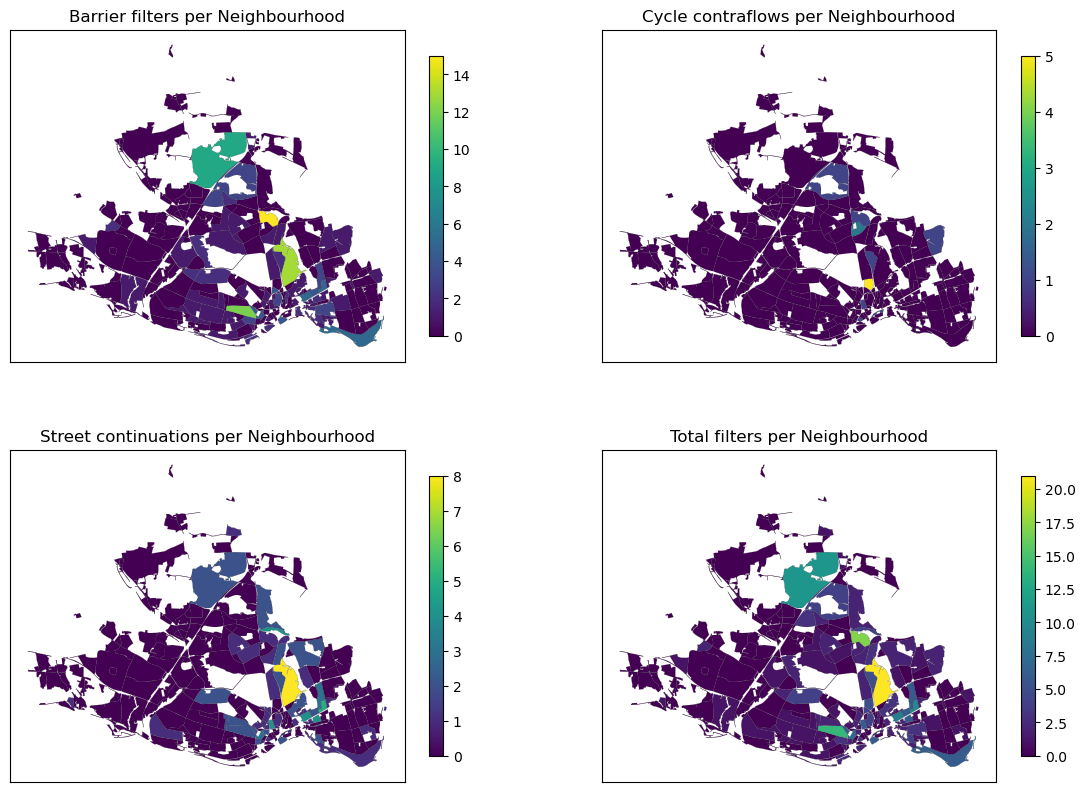

In [65]:
## read geopackage and join filters to neighbourhoods

# Read GeoPackage 
neighbourhoods = gpd.read_file(file_path, driver="GPKG")


## alter neighbourhoods before joining
# buffer to ensure all filters are captured
neighbourhoods['geometry'] = neighbourhoods['geometry'].buffer(5)

# reset neighbourhood crs
neighbourhoods = neighbourhoods.to_crs('EPSG:4326')




## spatial join
# Perform a spatial join between neighbourhoods and filters
joined_data = gpd.sjoin(neighbourhoods, filters, how="left", predicate="intersects")

# Count the number of each filter within each neighbourhood
filter_type_counts = joined_data.groupby(['ID', 'filter_type']).size().unstack(fill_value=0)

# Reset the index to make it more readable
filter_type_counts = filter_type_counts.reset_index()

# Merge the filter_type_counts DataFrame with the neighbourhoods GeoDataFrame on the ID column
neighbourhoods = neighbourhoods.merge(filter_type_counts, on='ID', how='left')

# find the total counts of each filter type per neighborhood
neighbourhoods['total_filter_types'] = neighbourhoods.iloc[:, 5:].sum(axis=1)

# Fill NaN values with 0 if necessary
neighbourhoods = neighbourhoods.fillna(0)


import matplotlib.pyplot as plt

# Create a figure with a 2x3 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

# Flatten the axs array to simplify indexing
axs = axs.flatten()

# Define the columns to plot
columns_to_plot = ['barrier or bollard', 'one-way bike', 'street continuation', 'total_filter_types']

# Define the corresponding titles
titles = ['Barrier filters', 'Cycle contraflows', 'Street continuations', 'Total filters']

# Loop through each column and plot on the corresponding subplot
for i, (column, title) in enumerate(zip(columns_to_plot, titles)):
    if i < len(axs):  # Ensure not to exceed the number of subplots
        neighbourhoods.plot(column=column, cmap='viridis', legend=True, ax=axs[i], linewidth=0.1, edgecolor='0.1', legend_kwds={'shrink': 0.8})
        axs[i].set_title(f'{title} per Neighbourhood')
        axs[i].tick_params(left=False, bottom=False)  # Hide tick marks on both axes
        axs[i].set_xticklabels([])  # Hide x-axis labels
        axs[i].set_yticklabels([])  # Hide y-axis labels

# Remove the empty subplot (if any)
for j in range(len(axs), len(columns_to_plot), -1):
    if j-1 < len(axs):  # Check if the index is valid
        fig.delaxes(axs[j-1])

# Adjust layout and show the plot with reduced hspace
#plt.tight_layout(h_pad=1)
plt.show()

